## Convolutional Neural Networks

In [15]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

### Installing some main torch library and other essential tools.
There are a number of imports for torch. (These are not included with ISLP, so must be installed separately.) All of them are used to specify sequentially-structured networks.

In [16]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError,R2Score)
from torchinfo import summary

 The package pytorch_lightning is a somewhat higher-level interface to torch that simplifies the specification and fitting of models by reducing the amount of boilerplate code needed (compared to using torch alone).

In order to reproduce results we use seed_everything(). We will also instruct torch to use deterministic algorithms where possible.

In [17]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
#We will use several datasets shipped with torchvision for our examples
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)
# The glob() function from the glob module is used to find all files matching wildcard characters
from glob import glob
import json

Seed set to 0


In this section we fit a CNN to the CIFAR100 data, which is available in the torchvision package. It is arranged in a similar fashion as the MNIST data.

In [18]:
(cifar_train, 
 cifar_test) = [CIFAR100(root="data",
                         train=train,
                         download=True)
             for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


In [19]:
#Sanity Check
cifar_train.data.shape

(50000, 32, 32, 3)

Once we have downloaded the data, we do a bit of preprocessing.The pixel values are rescaled to be floating point numbers from 0 to 1 instead of integers from 0 to 255.Also we just transpose the arrays, to just reorder them.

Creating the data module is similar to the MNIST example.

In [20]:
max_num_workers = rec_num_workers()

transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                            torch.tensor(cifar_test.targets))

cifar_dm = SimpleDataModule(cifar_train,
                            cifar_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=128)

for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


Before we start, we look at some of the training images.The example below also illustrates that TensorDataset objects can be indexed with integers, i.e., we are choosing random images from the training data by indexing cifar_train. In order to display correctly, we must reorder the dimensions by a call to np.transpose().

Here the imshow() method recognizes from the shape of its argument that it is a 3-dimensional array, with the last dimension indexing the three RGB color channels.

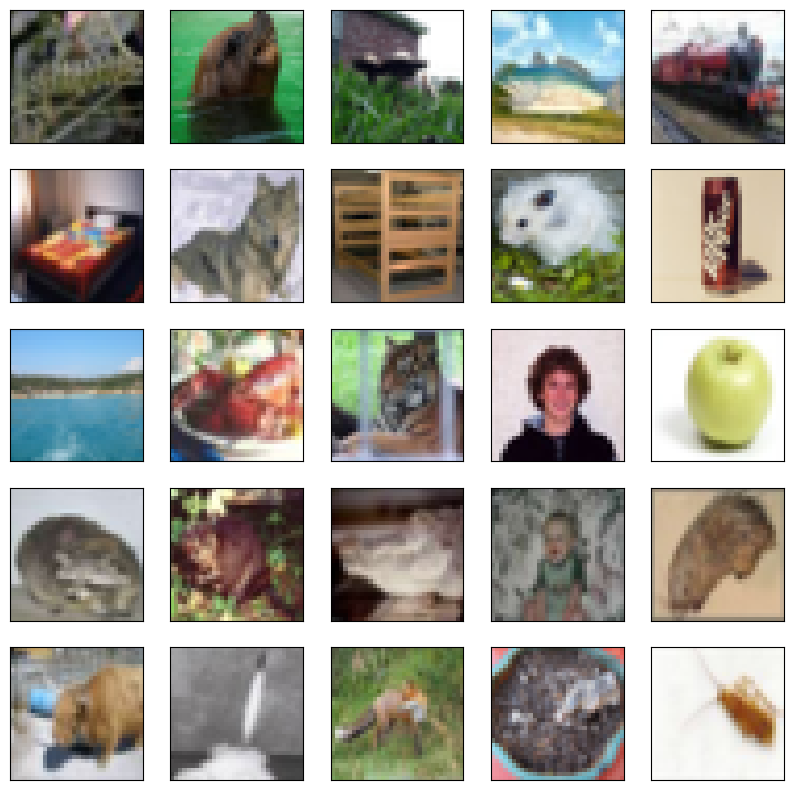

In [21]:
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                      [1,2,0]),
                                      interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

Now we build our own layer which serves as a building block.This is help us make the CIFAR 100 Network layers, using python constructs, more easily.By 'layers', we mean each of the convolution and max pool layers.

As in our previous examples, we overwrite the __init__() and forward() methods of nn.Module. This user-defined module can now be used in ways just like nn.Linear() or nn.Dropout().

In [22]:
class BuildingBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(BuildingBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels = in_channels,
                             out_channels = out_channels,
                             kernel_size = (3,3),
                             padding = 'same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

Note here we have used {padding='same'} command to nn.Conv2d(...) which means that the image matrix and feature map will have dimensions.

In forming our deep learning model for the CIFAR100 data, we use several of our BuildingBlock() modules sequentially. This simple example illustrates some of the power of torch. Users can define modules of their own, which can be combined in other modules. Ultimately, everything is fit by a generic trainer.

In [23]:
class CIFARModel(nn.Module):

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512), # 256 channels in input
                                    nn.ReLU(),
                                    nn.Linear(512, 100)) # 100 classes
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

So the main difference here is that we have programmatically gone in a loop and build the layers (using Sequential again with a * argument), reducing the effort (code as well) from our side.This unlike for the MNIST data set where we build all the layers one by one.This betterment is much more of a compact way to go about building CNNs.

We build the model and look at the summary (a bit long in this case). (We had created examples of X_ earlier.)
Notice we almost have a million parameters.

In [24]:
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

By studying the size of the parameters, we can see that the channels halve in both dimensions after each of these max-pooling operations. After the last of these we have a layer with 256 channels of dimension 2 by 2.These are then flattened to a dense layer of size 1,024.

Up to now, we have been using a default optimizer in SimpleModule(). For these data, experiments show that a smaller learning rate performs better than the default 0.01. We use a custom optimizer here with a learning rate of 0.001. Besides this, the logging and training follow a similar pattern to our previous examples. The optimizer takes an argument params that informs the optimizer which parameters are involved in SGD (stochastic gradient descent).

We saw earlier that entries of a module’s parameters are tensors. In passing the parameters to the optimizer we are doing more than simply passing arrays; part of the structure of the graph is encoded in the tensors themselves.

In [25]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model,
                                    num_classes=100,
                                    optimizer=cifar_optimizer)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [26]:
cifar_trainer = Trainer(deterministic=True,
                        max_epochs=25,
                        logger=cifar_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,
                  datamodule=cifar_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=25` reached.


This model took 16 minutes to run on a Windows 11 device with 4 cores and achieves about 42% accuracy on the test data. Although this is not terrible for 100-class data (a random classifier gets 1% accuracy), searching the web we see results around 75%. Typically it takes a lot of architecture carpentry, fiddling with regularization, and time, to achieve such results.

Let’s take a look at the validation and training accuracy across epochs.

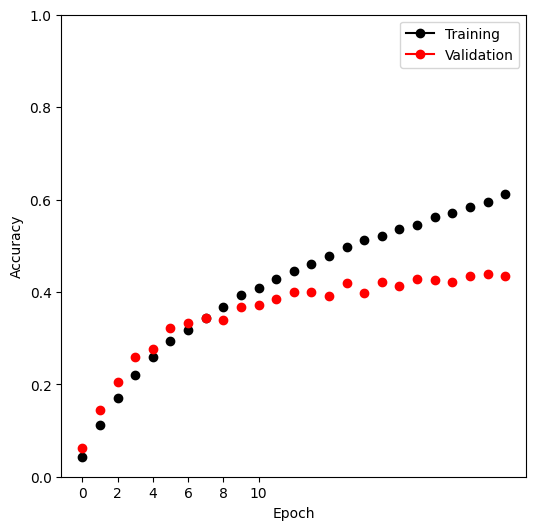

In [28]:
#summary plot func
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax


log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

The validation data levels off quickly so maybe having 30 or higher epochs won't help much as only the training data will improve.

Finally, we evaluate our model on our test data.

In [30]:
cifar_trainer.test(cifar_module,
                   datamodule=cifar_dm)

del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.43619999289512634
        test_loss            2.301541328430176
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### IMDB Document Classification

We now implement models for sentiment classification on the IMDB dataset. We are using a preprocessed version of the IMDB dataset found in the keras package. As keras uses tensorflow, a different tensor and deep learning library, we have converted the data to be suitable for torch. The code used to convert from keras is available in the module ISLP.torch._make_imdb. It requires some of the keras packages to run. These data use a dictionary of size 10,000.

We have stored three different representations of the review data for this lab:

load_tensor(), a sparse tensor version usable by torch; \
load_sparse(), a sparse matrix version usable by sklearn, since we will compare with a lasso fit;\
load_sequential(), a padded version of the original sequence representation, limited to the last 500 words of each review.

In [ ]:
(imdb_seq_train,
 imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

The datasets imdb_seq_train and imdb_seq_test are both instances of the class TensorDataset. The tensors used to construct them can be found in the tensors attribute, with the first tensor the features X and the second the outcome Y. We have taken the first row of features and stored it as padded_sample. In the preprocessing used to form these data, sequences were padded with 0s in the beginning if they were not long enough, hence we remove this padding by restricting to entries where padded_sample > 0. We then provide the first 12 words of the sample review.

We can find these words in the lookup dictionary from the ISLP.torch.imdb module.

For our first model, we have created a binary feature for each of the 10,000 possible words in the dataset, with an entry of one in the entry if word 
appears in review .As most reviews are quite short, such a feature matrix has over 98% zeros. These data are accessed using load_tensor() from the ISLP library.Also we will use a two-layer model for our first model.

In [33]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

In [34]:
max_num_workers=10
(imdb_train,
 imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)

Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [36]:
class IMDBModel(nn.Module):

    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

We’ll again use a smaller learning rate for these data, hence we pass an optimizer to the SimpleModule. Since the reviews are classified into positive or negative sentiment, we use SimpleModule.binary_classification(). {Our use of binary_classification() instead of classification() is due to some subtlety in how torchmetrics.Accuracy() works, as well as the data type of the targets.}

Having loaded the datasets into a data module and created a SimpleModule, the remaining steps are familiar.
Evaluating the test error yields roughly 86% accuracy.

In [37]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer)

imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=25,
                       logger=imdb_logger,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
C:\Users\steph\anaconda3\envs\islp2\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=25` reached.


In [38]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8534799814224243
        test_loss           0.9214787483215332
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9214787483215332, 'test_accuracy': 0.8534799814224243}]

### Lasso Comparision
We now fit a lasso logistic regression model using LogisticRegression() from sklearn. Since sklearn does not recognize the sparse tensors of torch, we use a sparse matrix that is recognized by sklearn.

In [40]:
((X_train, Y_train),
 (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation=2000,
                                 random_state=0,
                                 root='data/IMDB')

lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))

Retrieving "IMDB_X_test.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


With LogisticRegression() the regularization parameter C is specified as the inverse of lambda.There are several solvers for logistic regression; here we use liblinear which works well with the sparse input format.

The coefficient and intercepts have an extraneous dimension which can be removed by the np.squeeze() function.

In [41]:
logit = LogisticRegression(penalty='l1', 
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)

coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)


coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

We’ll now make a plot to compare our neural network results with the lasso.

Notice the use of %%capture, which suppresses the displaying of the partially completed figure. This is useful when making a complex figure, since the steps can be spread across two or more cells. We now add a plot of the lasso accuracy, and display the composed figure by simply entering its name at the end of the cell.

In [42]:
%%capture
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                    ['Training', 'Validation', 'Test'],
                    ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 '.--',
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)

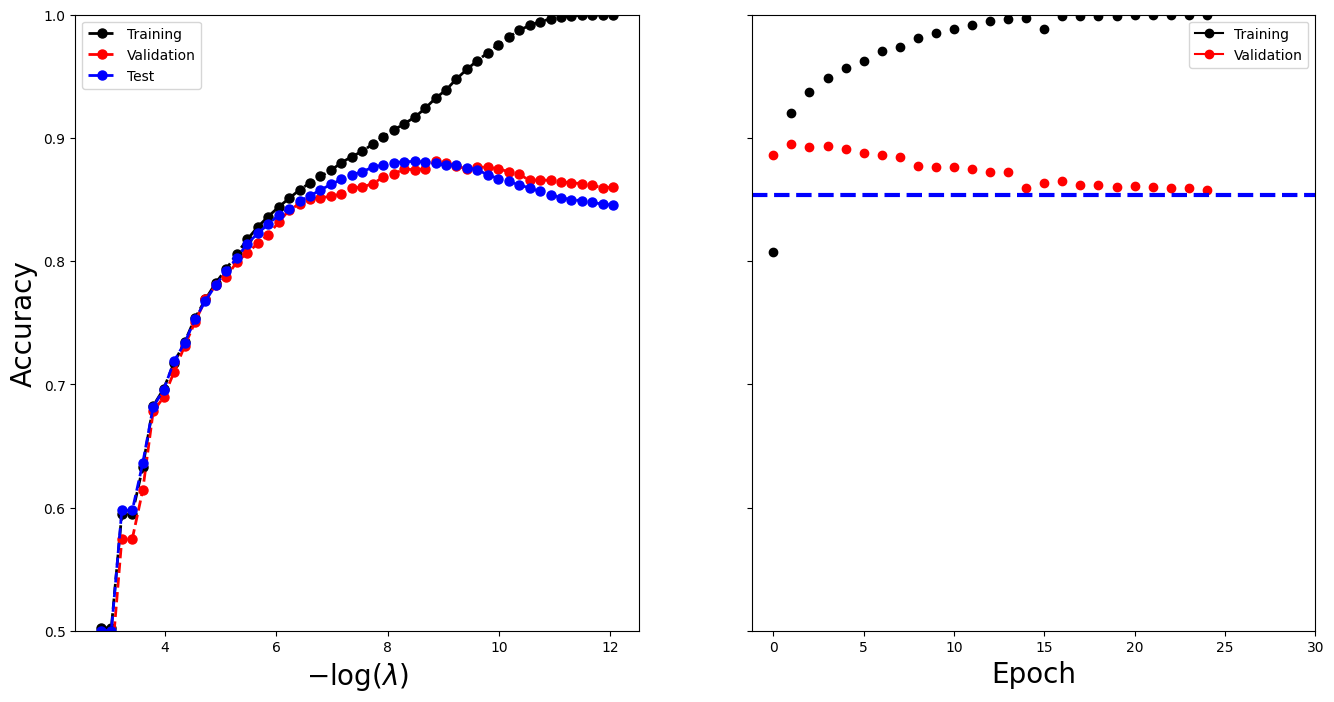

In [43]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col='accuracy',
             ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig

From the graphs we see that the accuracy of the lasso logistic regression peaks at about 0.88, as it does for the neural network.

Once again, we end with a cleanup.

In [44]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

### RNN

Here we fit a simple LSTM RNN for sentiment prediction to the IMDb movie-review data.For an RNN we use the sequence of words in a document, taking their order into account. We load the preprocessed data. A script that details the preprocessing can be found in the ISLP library. Notably, since more than 90% of the documents had fewer than 500 words, we set the document length to 500. 
For longer documents, we used the last 500 words, and for shorter documents, we padded the front with blanks.

In [45]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_num_workers)
                               )

In [46]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            batch_first=True)
        self.dense = nn.Linear(32, 1)
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

In [48]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0][:10],
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [49]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

lstm_trainer = Trainer(deterministic=True,
                       max_epochs=20,
                       logger=lstm_logger,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module,
                 datamodule=imdb_seq_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


In [50]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.855400025844574
        test_loss           0.7781291604042053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7781291604042053, 'test_accuracy': 0.855400025844574}]

We once again show the learning progress, followed by cleanup.

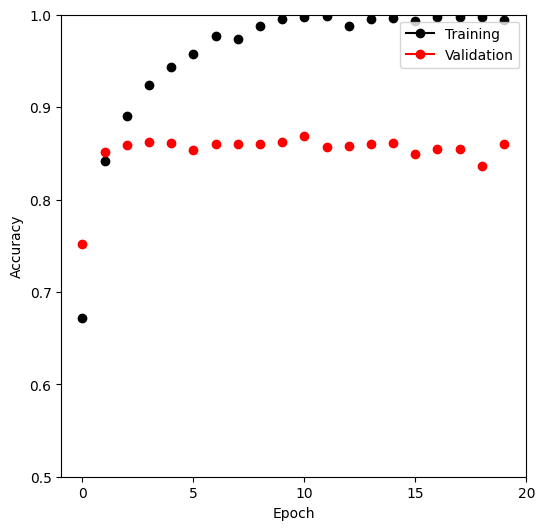

In [52]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])


del(lstm_model,
    lstm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)